<a href="https://colab.research.google.com/github/HHAKS19/face-emotion-detection/blob/main/Face_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required packages
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator



##Initialize image data generator with rescaling

In [ ]:
batch_size  = 128

train_data_gen = ImageDataGenerator(rescale=1./255,horizontal_flip= True)
validation_data_gen = ImageDataGenerator(rescale=1./255)

## Preprocess all train images

In [ ]:
# 
train_generator = train_data_gen.flow_from_directory(
        '/content/drive/MyDrive/Face_data/train',
        target_size=(48, 48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical') # since we use categorical_crossentropy loss, we need categorical labels,label_mode(int,binary,categorical) )



Found 28821 images belonging to 7 classes.


## Preprocess all test images

In [ ]:
validation_generator = validation_data_gen.flow_from_directory(
        '/content/drive/MyDrive/Face_data/validation',
        target_size=(48, 48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 7066 images belonging to 7 classes.


## Create model structure

In [ ]:
from tensorflow.keras.optimizers import Adam
emotion_model = Sequential()

#1st and 2nd CNN layer
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

#3rd and 4th CNN layer
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))


emotion_model.add(Flatten())

#FC1
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))

#FC2
emotion_model.add(Dense(512, activation='relu'))
emotion_model.add(Dropout(0.5))

emotion_model.add(Dense(7, activation='softmax'))


emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
emotion_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)        

## Model Checkpoint 

In [ ]:
#Callbacks to stop training when there's enough valid data

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./emotion_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,early_stopping,reduce_learningrate]

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])



## Train the neural network/model

In [ ]:
model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=50,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size,
        callbacks = callbacks_list
        )

Epoch 1/50
225/225 [==============================] - 5540s 24s/step - loss: 1.8349 - accuracy: 0.2398 - val_loss: 1.8400 - val_accuracy: 0.2580

Epoch 00001: val_accuracy improved from -inf to 0.25795, saving model to ./emotion_model.h5
Epoch 2/50
225/225 [==============================] - 63s 280ms/step - loss: 1.8034 - accuracy: 0.2556 - val_loss: 1.7308 - val_accuracy: 0.3080

Epoch 00002: val_accuracy improved from 0.25795 to 0.30795, saving model to ./emotion_model.h5
Epoch 3/50
225/225 [==============================] - 63s 278ms/step - loss: 1.6778 - accuracy: 0.3376 - val_loss: 1.5959 - val_accuracy: 0.3783

Epoch 00003: val_accuracy improved from 0.30795 to 0.37827, saving model to ./emotion_model.h5
Epoch 4/50
225/225 [==============================] - 63s 282ms/step - loss: 1.5879 - accuracy: 0.3851 - val_loss: 1.5185 - val_accuracy: 0.4210

Epoch 00004: val_accuracy improved from 0.37827 to 0.42102, saving model to ./emotion_model.h5
Epoch 5/50
225/225 [===================

## Plotting

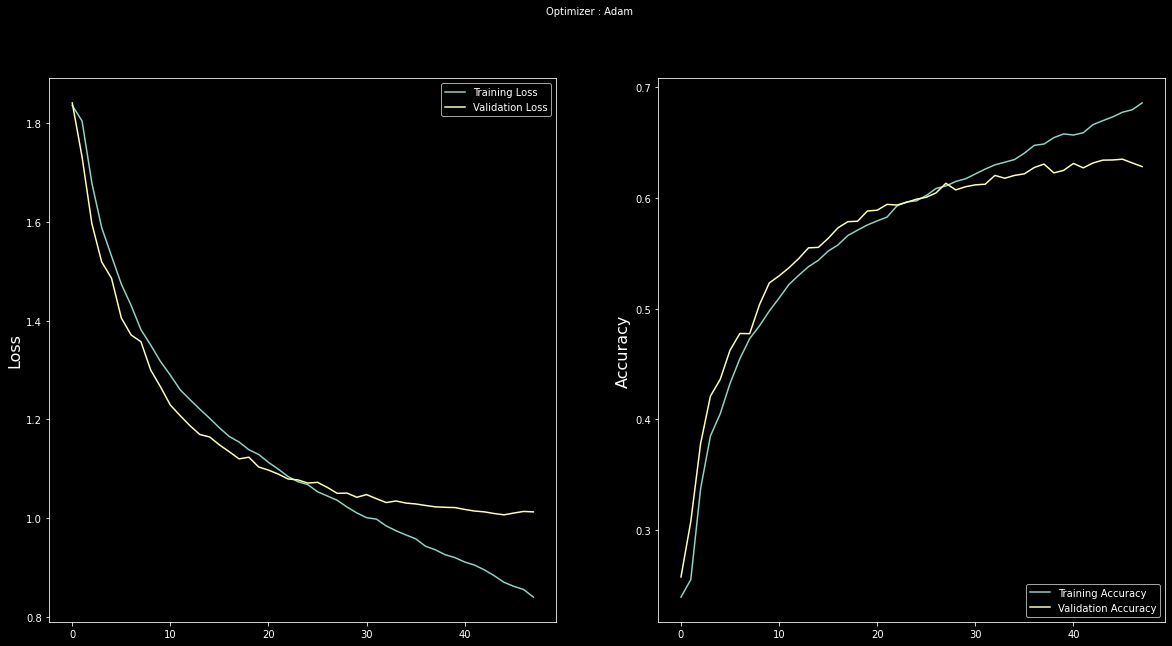

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_info.history['loss'], label='Training Loss')
plt.plot(model_info.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_info.history['accuracy'], label='Training Accuracy')
plt.plot(model_info.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# save trained model weight in .h5 file
emotion_model.save_weights('/content/drive/MyDrive/Face_data/emotion_model_w.h5')

#Save the model file

In [ ]:
emotion_model.save('/content/drive/MyDrive/Face_data/emotion_model.h5')

## Test the model with webcam

In [ ]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(r'/content/drive/MyDrive/Face_data/haarcascade_frontalface_default.xml')
classifier =load_model(r'/content/drive/MyDrive/Face_data/emotion_model.h5')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)



while True:
    # ret is a boolean regarding whether or not there was a return at all, at the frame is each frame that is returned. 
    ret, frame = cap.read() 
    if not ret:
        break                        
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #detect faces
    faces = face_classifier.detectMultiScale(gray) 

    # take each face available on the camera and Preprocess it
    for (x,y,w,h) in faces:
        #image,start,end,color(RGB),thinkness
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)  #color = light cyan
        roi_gray = gray[y:y+h,x:x+w] #crop the image
        roi_graycrop = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  #resize an image and use interpolation for true area



        if np.sum([roi_gray])!=0:
            #normalize the data so everything lies between 0 and 1
            roi = roi_graycrop.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict(roi)[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): #f we get a key, and that key is a q, we will exit the while loop with a break, which then runs:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
#IF WE WANT TO RECORD AND SAVE THE RECORDED FILE
import numpy as np
import cv2

cap = cv2.VideoCapture(1)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out.write(frame)
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()